In [1]:
import sys
import pandas as pd
import ast
import pickle
import random
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.utils import from_networkx
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
import utils
import models
import dataset
import train_utils

In [2]:
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=32, neg_weight=8.0):
        super().__init__()
        self.neg_weight = neg_weight
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(output_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # 1 logit
        )
    
    def forward(self, data, query_node_indices):
        # data.x: (num_nodes, feature_dim)
        # data.edge_index: (2, num_edges)
        data.x = data.x.to(torch.float32)
        
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        x = F.relu(x)
        
        # Only select embeddings for the query nodes
        query_embeddings = x[query_node_indices]
        
        logits = self.mlp(query_embeddings)
        return logits.squeeze(-1)

    def predict_proba(self, data, query_node_indices):
        with torch.no_grad():
            logits = self.forward(data, query_node_indices)
            return torch.sigmoid(logits)

    def compute_loss(self, logits, labels):
        weights = torch.ones_like(labels, device=labels.device)
        weights[labels == 0] = self.neg_weight
        return F.binary_cross_entropy_with_logits(
            logits,
            labels.float(),
            weight=weights
        )


In [3]:
class PerturbationDataset(Dataset):
    def __init__(self, label_df, active_nodes_df, node_features_df, node_idx_mapping, device='cpu'):
        self.label_df = label_df.reset_index(drop=True)
        self.device = device
        self.node_idx_mapping = node_idx_mapping  # Mapping from Ensembl ID to node index

        # Build mapping from (Cell Line) to list of active genes (may be useful later)
        self.cell_line_to_active = (
            active_nodes_df.groupby("Cell Line")["Gene"]
            .apply(list)
            .to_dict()
        )

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        row = self.label_df.iloc[idx]
        target_id = row["Target"]
        label = torch.tensor(row["Perturbed"], dtype=torch.float32).to(self.device)

        # Map target Ensembl ID to node index
        try:
            target_idx = self.node_idx_mapping[target_id]
        except KeyError:
            raise ValueError(f"Target node '{target_id}' not found in node_idx_mapping.")

        return target_idx, label

def collate_function(batch):
    target_indices, labels = zip(*batch)
    target_indices = torch.tensor(target_indices, dtype=torch.long)
    labels = torch.stack(labels)
    return target_indices, labels

In [4]:
id_map_df = pd.read_csv('../data/id_mappings/gene_ref.tsv', sep='\t')
id_map_df

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Alias symbols,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID,Ensembl gene ID,Mouse genome database ID,Pubmed IDs,Alias names
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,MGI:2152878,2591067,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,MGI:1917115,"11815617, 11072063",NaN
3,HGNC:6,A1S9T,"symbol withdrawn, see [HGNC:12469](/data/gene-...",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,MGI:2449119,"2408344, 9697696",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49354,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",Approved,ZYG11,FLJ13456,1p32.3,AB051517,NM_024646,79699.0,ENSG00000162378,MGI:2685277,11214970,NaN
49355,HGNC:13200,ZYX,zyxin,Approved,NaN,NaN,7q34,X95735,NM_003461,7791.0,ENSG00000159840,MGI:103072,"8917469, 8940160",NaN
49356,HGNC:51695,ZYXP1,zyxin pseudogene 1,Approved,NaN,NaN,8q24.23,NaN,NaN,NaN,ENSG00000274572,NaN,NaN,NaN
49357,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Approved,NaN,"KIAA0399, ZZZ4, FLJ10821",17p13.2,BC035319,NM_015113,23140.0,ENSG00000074755,MGI:2444286,9455477,NaN


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_utils.set_seed(42)

In [23]:
with open('../data/embeddings.pkl', 'rb') as f:
    node_features_df = pickle.load(f)

node_features_df['Concat Embedding'] = node_features_df['PINNACLE Embedding']# + node_features_df['SubCell Embedding'] + node_features_df['ESM Embedding']

train_df = pd.read_csv('../data/train.csv', index_col=0)

active_nodes_df = pd.read_csv('../data/expression_reference/expression_reference.csv', index_col=0)

G = nx.read_edgelist('../data/networks/global_ppi_edgelist.txt')

ensembl_to_node = dict(zip(id_map_df['Ensembl gene ID'], id_map_df['Approved symbol']))
node_to_ensembl = dict(zip(id_map_df['Approved symbol'], id_map_df['Ensembl gene ID']))

G = nx.relabel_nodes(G, node_to_ensembl)

# Get set of nodes that have features
valid_nodes = set(node_features_df['Ensembl ID'])

# Remove nodes from G that are not in valid_nodes
G.remove_nodes_from([n for n in list(G.nodes) if n not in valid_nodes])

node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}

train_df = train_df[train_df['Target'].isin(G.nodes())]

# Convert to edge_index format
data = from_networkx(G)

features = torch.stack([
    torch.tensor(node_features_df.set_index('Ensembl ID').loc[idx]['Concat Embedding'])
    for idx in G.nodes()
])
data.x = features

train_dataset = PerturbationDataset(
    train_df.iloc[:int(0.9*len(train_df))],
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

val_dataset = PerturbationDataset(
    train_df.iloc[int(0.9*len(train_df)):],
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

input_dim = len(node_features_df['Concat Embedding'][0])

model = GNNClassifier(
    input_dim=input_dim, 
    hidden_dim=128, 
    output_dim=32, 
    neg_weight=8.0
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_function)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_function)

In [24]:
train_df

,Target,Perturbed,Cell Line,ID,Experiment
123132,ENSG00000129562,True,K562,AACGTCAAGCTACTGT-13,ReplogleWeissman2022_K562_essential
146635,ENSG00000137656,True,K562,AAACCCAGTTATTCTC-3,ReplogleWeissman2022_K562_essential
212090,ENSG00000166337,True,K562,AAACCCATCGTCGGGT-17,ReplogleWeissman2022_K562_essential
120978,ENSG00000128422,True,K562,AACCCAAAGATTGTGA-36,ReplogleWeissman2022_K562_essential
97151,ENSG00000115947,True,K562,AAAGTGAAGGTACTGG-32,ReplogleWeissman2022_K562_essential
...,...,...,...,...,...
13842,ENSG00000051180,True,K562,AAACCCACACTTGAGT-41,ReplogleWeissman2022_K562_essential
12608,ENSG00000047249,True,K562,AAACCCATCCACCTCA-8,ReplogleWeissman2022_K562_essential
139685,ENSG00000135521,True,K562,AAACGAATCACCACAA-18,ReplogleWeissman2022_K562_essential
5762,ENSG00000138190,True,K562,ATCGAGTGTCAATGTC,GasperiniShendure2019_lowMOI


In [25]:
# Training loop for one epoch
def train_one_epoch(model, data, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    y_true, y_pred, y_prob = [], [], []
    class_counts = {0: 0, 1: 0}

    for batch_idx, (query_node_indices, labels) in enumerate(dataloader):
        query_node_indices = query_node_indices.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(data, query_node_indices)
        loss = model.compute_loss(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Predictions & metrics tracking
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

        total_loss += loss.item()

        # Track class distribution
        for label in labels.cpu().numpy():
            class_counts[int(label)] += 1

        if (batch_idx + 1) % 10 == 0:
            print(f"[Batch {batch_idx+1}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    metrics = train_utils.compute_metrics(np.array(y_true), np.array(y_pred), np.array(y_prob))
    metrics['loss'] = avg_loss

    print(f"\n[Training] Loss: {avg_loss:.4f} | Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['auc']:.4f}")
    print(f"Class distribution: 0 -> {class_counts[0]}, 1 -> {class_counts[1]}")

    return metrics

# Evaluation loop (no gradients)
def evaluate(model, data, dataloader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    class_counts = {0: 0, 1: 0}

    with torch.no_grad():
        for query_node_indices, labels in dataloader:
            query_node_indices = query_node_indices.to(device)
            labels = labels.to(device)

            logits = model(data, query_node_indices)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

            for label in labels.cpu().numpy():
                class_counts[int(label)] += 1

    metrics = train_utils.compute_metrics(np.array(y_true), np.array(y_pred), np.array(y_prob))

    print(f"\n[Evaluation] Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['auc']:.4f}")
    print(f"Class distribution: 0 -> {class_counts[0]}, 1 -> {class_counts[1]}")

    return metrics, y_true, y_pred, y_prob

# Training loop across multiple epochs
num_epochs = 20
best_val_auc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    train_metrics = train_one_epoch(model, data, train_loader, optimizer, device)
    val_metrics, y_true_val, y_pred_val, y_prob_val = evaluate(model, data, val_loader, device)
    print([int(x) for x in y_true_val])
    print([int(x) for x in y_pred_val])

    # Save model if improved
    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"New best model saved with AUC: {best_val_auc:.4f}")



===== Epoch 1/20 =====
[Batch 10] Loss: 0.7371
[Batch 20] Loss: 1.8802
[Batch 30] Loss: 1.2965
[Batch 40] Loss: 0.8477
[Batch 50] Loss: 1.7507
[Batch 60] Loss: 1.2993
[Batch 70] Loss: 0.8133
[Batch 80] Loss: 1.3005
[Batch 90] Loss: 2.5281
[Batch 100] Loss: 0.6571
[Batch 110] Loss: 1.9572
[Batch 120] Loss: 3.0116
[Batch 130] Loss: 0.7544
[Batch 140] Loss: 1.2937
[Batch 150] Loss: 0.7697
[Batch 160] Loss: 1.8263
[Batch 170] Loss: 2.3723
[Batch 180] Loss: 0.7502
[Batch 190] Loss: 0.7526

[Training] Loss: 1.3526 | Precision: 0.8222 | Recall: 0.1347 | F1: 0.2315 | AUC: 0.4775
Class distribution: 0 -> 217, 1 -> 1373


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6654
Class distribution: 0 -> 21, 1 -> 156
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
model = train_utils.load_model(GNNClassifier, input_dim=input_dim, hidden_dim=128, output_dim=32, neg_weight=8.0, path="best_model.pt")

In [27]:
test_df = pd.read_csv('../data/test.csv')

test_dataset = PerturbationDataset(
    test_df,
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_function)

In [28]:
test_metrics, y_true, y_pred, y_prob = evaluate(model, data, test_loader, device)
print(test_metrics)


[Evaluation] Precision: 0.8872 | Recall: 0.7442 | F1: 0.8095 | AUC: 0.5410
Class distribution: 0 -> 51, 1 -> 391
{'precision': np.float64(0.8871951219512195), 'recall': np.float64(0.7442455242966752), 'f1': np.float64(0.8094575799721836), 'auc': np.float64(0.5409708640489443)}


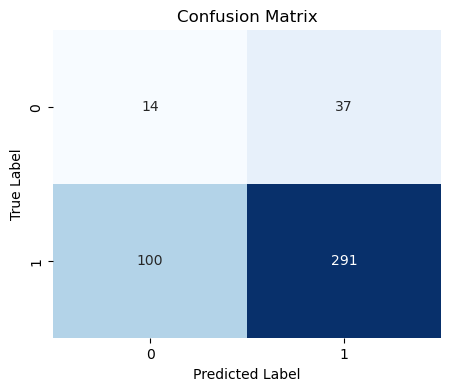

In [29]:
train_utils.plot_confusion_matrix(y_true, y_pred)

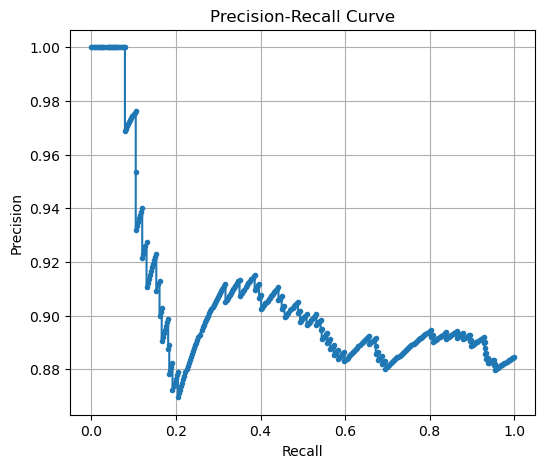

In [30]:
train_utils.plot_precision_recall(y_true, y_prob)

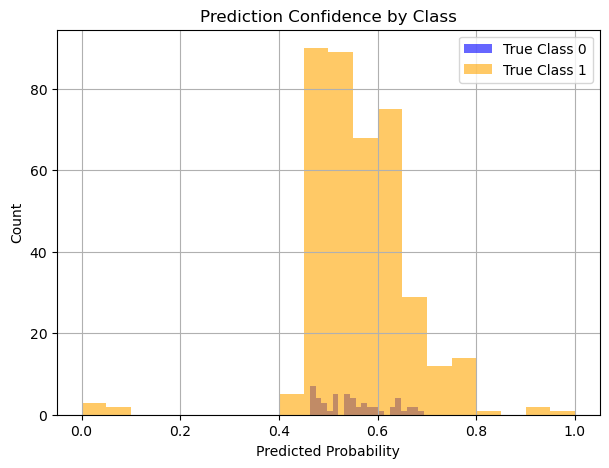

In [31]:
train_utils.plot_prediction_histograms(y_true, y_prob)

In [16]:
from sklearn.model_selection import KFold

# 5-fold cross validation setup
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Full train_df (already filtered to nodes in G) is used
full_train_df = train_df

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(full_train_df)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # Split train_df for this fold
    fold_train_df = full_train_df.iloc[train_idx]
    fold_val_df = full_train_df.iloc[val_idx]

    # Build datasets
    train_dataset = PerturbationDataset(
        fold_train_df,
        active_nodes_df,
        node_features_df,
        node_to_idx,
        device=device
    )
    val_dataset = PerturbationDataset(
        fold_val_df,
        active_nodes_df,
        node_features_df,
        node_to_idx,
        device=device
    )

    # Build dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_function)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_function)

    # Initialize model and optimizer fresh for each fold
    input_dim = len(node_features_df['Concat Embedding'][0])
    model = GNNClassifier(
        input_dim=input_dim, 
        hidden_dim=128, 
        output_dim=32, 
        neg_weight=8.0
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

    best_val_auc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f"\n----- Epoch {epoch}/{num_epochs} -----")
        train_metrics = train_one_epoch(model, data, train_loader, optimizer, device)
        val_metrics, y_true_val, y_pred_val, y_prob_val = evaluate(model, data, val_loader, device)

        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            torch.save(model.state_dict(), f'best_model_fold_{fold}.pt')
            print(f"New best model for fold {fold} saved with AUC: {best_val_auc:.4f}")

    print(f"\n=== Fold {fold} Best AUC: {best_val_auc:.4f} ===")
    fold_results.append(best_val_auc)

print(f"\n===== Cross-validation results =====")
print(f"AUC per fold: {fold_results}")
print(f"Mean AUC: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")



===== Fold 1/5 =====

----- Epoch 1/10 -----
[Batch 10] Loss: 0.7296
[Batch 20] Loss: 1.2995
[Batch 30] Loss: 1.2972
[Batch 40] Loss: 0.7265
[Batch 50] Loss: 1.2959
[Batch 60] Loss: 1.8816
[Batch 70] Loss: 1.3231
[Batch 80] Loss: 1.2974
[Batch 90] Loss: 2.4740
[Batch 100] Loss: 2.4492
[Batch 110] Loss: 0.7264
[Batch 120] Loss: 1.2944
[Batch 130] Loss: 2.4310
[Batch 140] Loss: 1.2944
[Batch 150] Loss: 1.3129
[Batch 160] Loss: 1.2981
[Batch 170] Loss: 2.9859

[Training] Loss: 1.3480 | Precision: 0.8846 | Recall: 0.0188 | F1: 0.0369 | AUC: 0.4899
Class distribution: 0 -> 192, 1 -> 1221


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6761
Class distribution: 0 -> 46, 1 -> 308
New best model for fold 0 saved with AUC: 0.6761

----- Epoch 2/10 -----
[Batch 10] Loss: 1.2894
[Batch 20] Loss: 2.4660
[Batch 30] Loss: 0.7270
[Batch 40] Loss: 1.2854
[Batch 50] Loss: 0.7260
[Batch 60] Loss: 1.2951
[Batch 70] Loss: 1.2851
[Batch 80] Loss: 1.2810
[Batch 90] Loss: 1.8653
[Batch 100] Loss: 1.8484
[Batch 110] Loss: 1.8399
[Batch 120] Loss: 1.8643
[Batch 130] Loss: 1.2851
[Batch 140] Loss: 1.2897
[Batch 150] Loss: 0.7107
[Batch 160] Loss: 1.8417
[Batch 170] Loss: 1.8129

[Training] Loss: 1.3425 | Precision: 0.9271 | Recall: 0.0729 | F1: 0.1352 | AUC: 0.5616
Class distribution: 0 -> 192, 1 -> 1221


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6923
Class distribution: 0 -> 46, 1 -> 308
New best model for fold 0 saved with AUC: 0.6923

----- Epoch 3/10 -----
[Batch 10] Loss: 1.2984
[Batch 20] Loss: 0.7674
[Batch 30] Loss: 1.2885
[Batch 40] Loss: 1.2705
[Batch 50] Loss: 1.2771
[Batch 60] Loss: 2.4568
[Batch 70] Loss: 0.6465
[Batch 80] Loss: 3.4071
[Batch 90] Loss: 2.6313
[Batch 100] Loss: 1.2818
[Batch 110] Loss: 1.2645
[Batch 120] Loss: 1.8351
[Batch 130] Loss: 0.7337
[Batch 140] Loss: 0.6692
[Batch 150] Loss: 1.9127
[Batch 160] Loss: 1.3080
[Batch 170] Loss: 1.2687

[Training] Loss: 1.3388 | Precision: 0.8863 | Recall: 0.3448 | F1: 0.4965 | AUC: 0.5610
Class distribution: 0 -> 192, 1 -> 1221


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6920
Class distribution: 0 -> 46, 1 -> 308

----- Epoch 4/10 -----
[Batch 10] Loss: 1.2874
[Batch 20] Loss: 0.7861
[Batch 30] Loss: 2.3751
[Batch 40] Loss: 1.2616
[Batch 50] Loss: 1.2405
[Batch 60] Loss: 0.7317
[Batch 70] Loss: 0.7174
[Batch 80] Loss: 1.3335
[Batch 90] Loss: 1.2766
[Batch 100] Loss: 1.3123
[Batch 110] Loss: 2.7588
[Batch 120] Loss: 0.7465
[Batch 130] Loss: 2.0224
[Batch 140] Loss: 0.6562
[Batch 150] Loss: 1.9720
[Batch 160] Loss: 1.2130
[Batch 170] Loss: 0.7642

[Training] Loss: 1.3259 | Precision: 0.9176 | Recall: 0.3284 | F1: 0.4837 | AUC: 0.5985
Class distribution: 0 -> 192, 1 -> 1221

[Evaluation] Precision: 0.9375 | Recall: 0.3896 | F1: 0.5505 | AUC: 0.6944
Class distribution: 0 -> 46, 1 -> 308
New best model for fold 0 saved with AUC: 0.6944

----- Epoch 5/10 -----
[Batch 10] Loss: 1.2472
[Batch 20] Loss: 0.7867
[Batch 30] Loss: 1.4407
[Batch 40] Loss: 1.2215
[Batch 50] Loss: 1.6168
[Batch 60]

/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.4676
Class distribution: 0 -> 44, 1 -> 310
New best model for fold 1 saved with AUC: 0.4676

----- Epoch 2/10 -----
[Batch 10] Loss: 1.9090
[Batch 20] Loss: 0.6877
[Batch 30] Loss: 0.6825
[Batch 40] Loss: 0.6865
[Batch 50] Loss: 1.3008
[Batch 60] Loss: 1.8869
[Batch 70] Loss: 1.2987
[Batch 80] Loss: 1.2978
[Batch 90] Loss: 1.3024
[Batch 100] Loss: 1.2921
[Batch 110] Loss: 0.7279
[Batch 120] Loss: 1.3105
[Batch 130] Loss: 1.8536
[Batch 140] Loss: 0.7525
[Batch 150] Loss: 1.2956
[Batch 160] Loss: 1.2997
[Batch 170] Loss: 0.7371

[Training] Loss: 1.3547 | Precision: 0.8595 | Recall: 0.2158 | F1: 0.3449 | AUC: 0.4914
Class distribution: 0 -> 194, 1 -> 1219


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.5693
Class distribution: 0 -> 44, 1 -> 310
New best model for fold 1 saved with AUC: 0.5693

----- Epoch 3/10 -----
[Batch 10] Loss: 1.2953
[Batch 20] Loss: 1.2950
[Batch 30] Loss: 1.8574
[Batch 40] Loss: 0.7453
[Batch 50] Loss: 2.3988
[Batch 60] Loss: 0.7586
[Batch 70] Loss: 1.3056
[Batch 80] Loss: 0.7828
[Batch 90] Loss: 1.2826
[Batch 100] Loss: 2.3965
[Batch 110] Loss: 1.2921
[Batch 120] Loss: 2.3495
[Batch 130] Loss: 1.3101
[Batch 140] Loss: 1.2979
[Batch 150] Loss: 0.7427
[Batch 160] Loss: 1.2941
[Batch 170] Loss: 1.3053

[Training] Loss: 1.3461 | Precision: 0.9556 | Recall: 0.0353 | F1: 0.0680 | AUC: 0.5298
Class distribution: 0 -> 194, 1 -> 1219

[Evaluation] Precision: 0.9050 | Recall: 0.7065 | F1: 0.7935 | AUC: 0.6239
Class distribution: 0 -> 44, 1 -> 310
New best model for fold 1 saved with AUC: 0.6239

----- Epoch 4/10 -----
[Batch 10] Loss: 1.2895
[Batch 20] Loss: 0.6809
[Batch 30] Loss: 1.2952
[Batch 40

/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.5931
Class distribution: 0 -> 48, 1 -> 305
New best model for fold 2 saved with AUC: 0.5931

----- Epoch 2/10 -----
[Batch 10] Loss: 0.7263
[Batch 20] Loss: 1.2974
[Batch 30] Loss: 1.2936
[Batch 40] Loss: 1.8625
[Batch 50] Loss: 0.7217
[Batch 60] Loss: 1.2845
[Batch 70] Loss: 0.7024
[Batch 80] Loss: 0.7246
[Batch 90] Loss: 1.2982
[Batch 100] Loss: 0.7007
[Batch 110] Loss: 1.3055
[Batch 120] Loss: 0.7135
[Batch 130] Loss: 0.7327
[Batch 140] Loss: 2.4282
[Batch 150] Loss: 0.7368
[Batch 160] Loss: 1.2848
[Batch 170] Loss: 0.7411

[Training] Loss: 1.3380 | Precision: 0.8512 | Recall: 0.0842 | F1: 0.1532 | AUC: 0.5596
Class distribution: 0 -> 190, 1 -> 1224

[Evaluation] Precision: 0.8000 | Recall: 0.0262 | F1: 0.0508 | AUC: 0.6261
Class distribution: 0 -> 48, 1 -> 305
New best model for fold 2 saved with AUC: 0.6261

----- Epoch 3/10 -----
[Batch 10] Loss: 1.2918
[Batch 20] Loss: 1.8839
[Batch 30] Loss: 1.2523
[Batch 40

/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Evaluation] Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6567
Class distribution: 0 -> 52, 1 -> 301
New best model for fold 3 saved with AUC: 0.6567

----- Epoch 2/10 -----
[Batch 10] Loss: 1.2937
[Batch 20] Loss: 1.2850
[Batch 30] Loss: 1.8238
[Batch 40] Loss: 0.7375
[Batch 50] Loss: 2.4117
[Batch 60] Loss: 1.2745
[Batch 70] Loss: 2.5785
[Batch 80] Loss: 1.8098
[Batch 90] Loss: 0.7247
[Batch 100] Loss: 0.7165
[Batch 110] Loss: 0.7337
[Batch 120] Loss: 1.9028
[Batch 130] Loss: 1.8625
[Batch 140] Loss: 1.2790
[Batch 150] Loss: 1.2751
[Batch 160] Loss: 1.8387
[Batch 170] Loss: 0.7117

[Training] Loss: 1.3219 | Precision: 0.8846 | Recall: 0.1124 | F1: 0.1994 | AUC: 0.5576
Class distribution: 0 -> 186, 1 -> 1228

[Evaluation] Precision: 0.9250 | Recall: 0.3688 | F1: 0.5273 | AUC: 0.6530
Class distribution: 0 -> 52, 1 -> 301

----- Epoch 3/10 -----
[Batch 10] Loss: 0.6565
[Batch 20] Loss: 1.3241
[Batch 30] Loss: 1.3257
[Batch 40] Loss: 0.6763
[Batch 50] Loss: 1.9252
[Batch 60]

0

[Evaluation] Precision: 0.9111 | Recall: 0.5243 | F1: 0.6656 | AUC: 0.6294
Class distribution: 0 -> 51, 1 -> 391


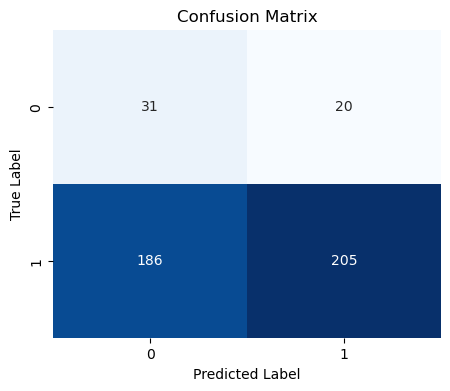

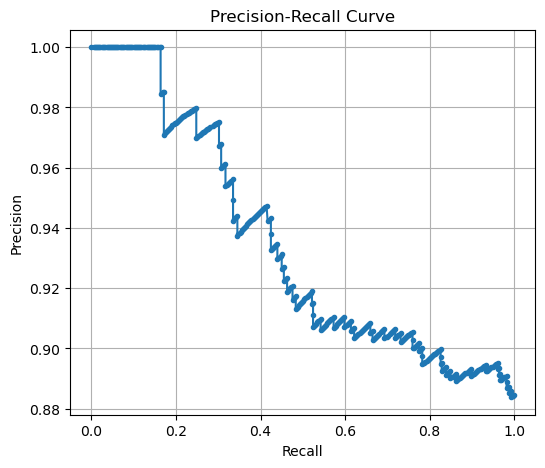

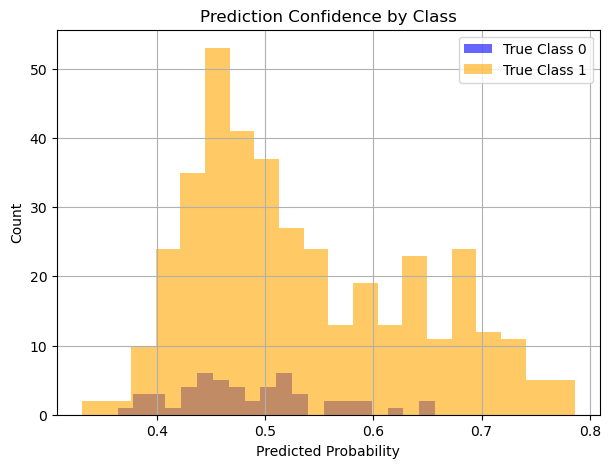

1

[Evaluation] Precision: 0.9282 | Recall: 0.4629 | F1: 0.6177 | AUC: 0.6545
Class distribution: 0 -> 51, 1 -> 391


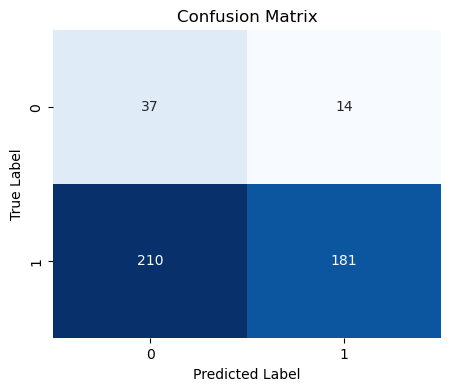

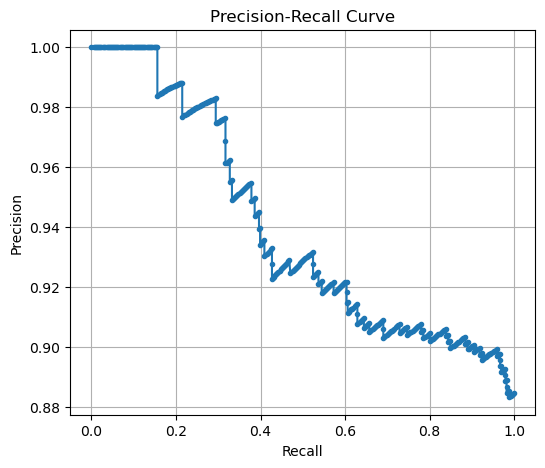

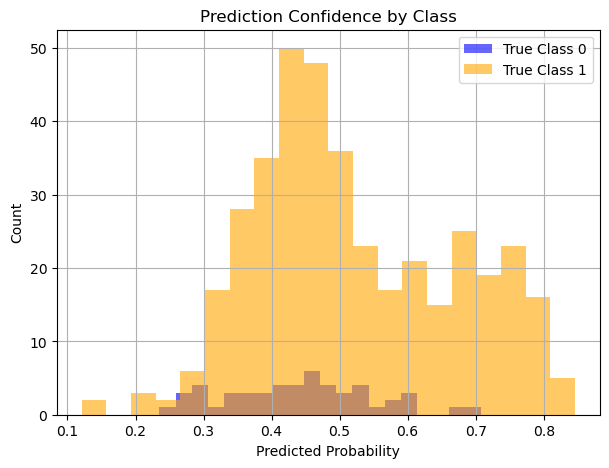

2

[Evaluation] Precision: 0.9085 | Recall: 0.6598 | F1: 0.7644 | AUC: 0.6292
Class distribution: 0 -> 51, 1 -> 391


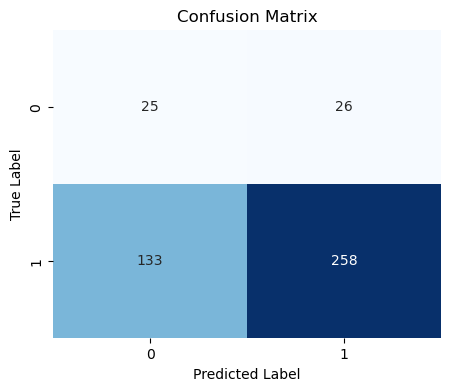

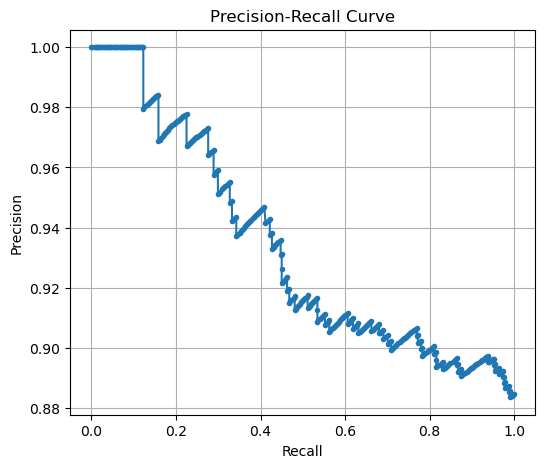

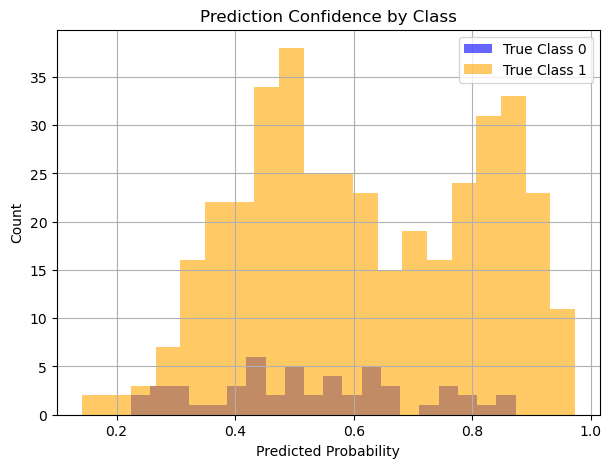

3

[Evaluation] Precision: 0.9041 | Recall: 0.6752 | F1: 0.7731 | AUC: 0.6310
Class distribution: 0 -> 51, 1 -> 391


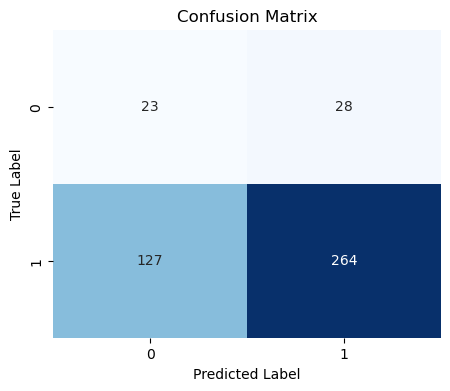

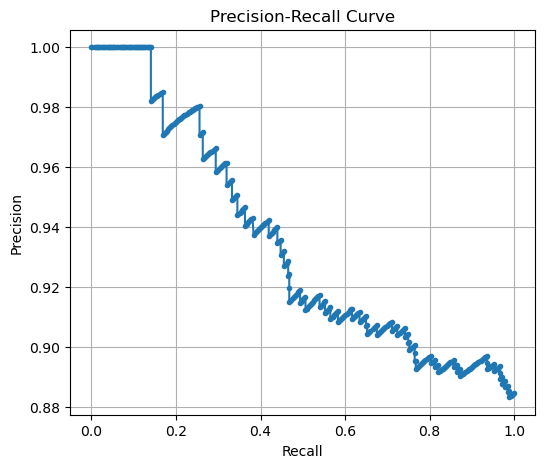

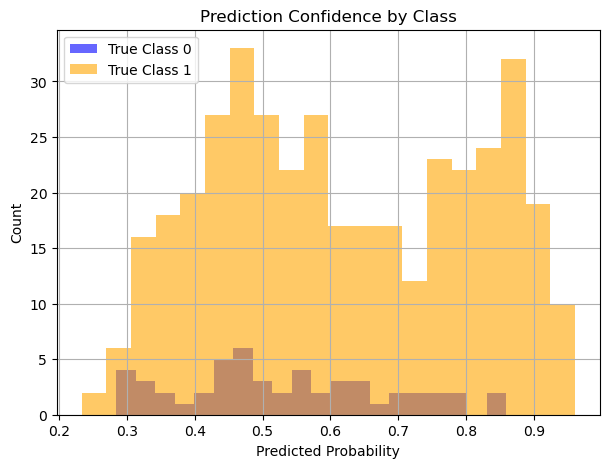

4

[Evaluation] Precision: 0.8982 | Recall: 0.6547 | F1: 0.7574 | AUC: 0.6077
Class distribution: 0 -> 51, 1 -> 391


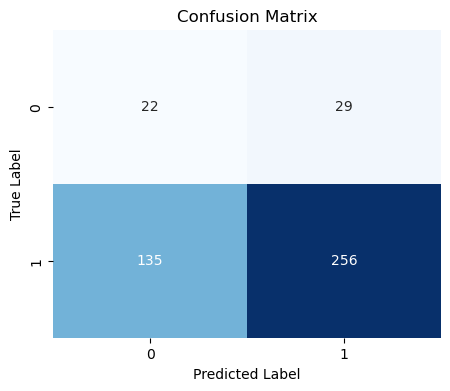

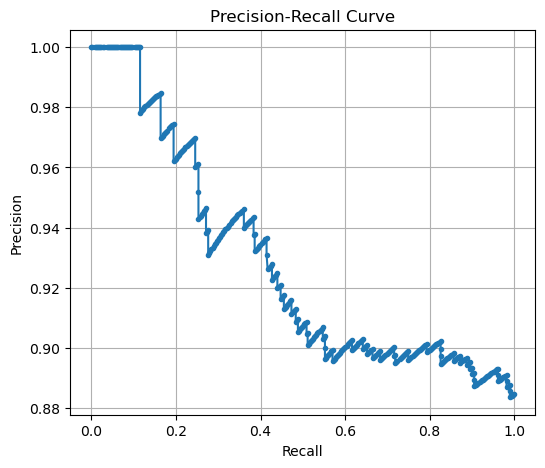

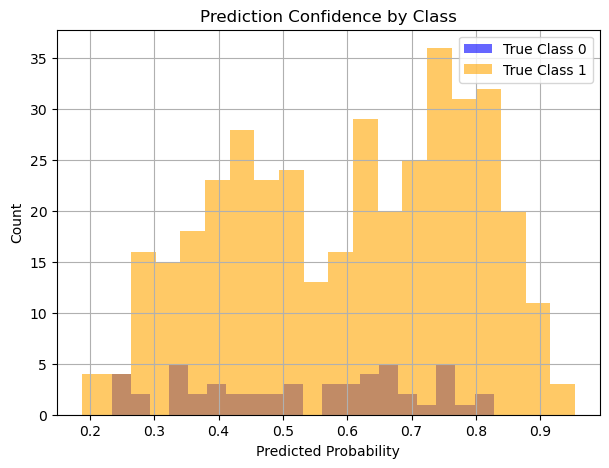

In [18]:
for i in range(5):
    print(i)

    model = train_utils.load_model(GNNClassifier, input_dim=input_dim, hidden_dim=128, output_dim=32, neg_weight=8.0, path=f"best_model_fold_{i}.pt")

    test_metrics, y_true, y_pred, y_prob = evaluate(model, data, test_loader, device)
    train_utils.plot_confusion_matrix(y_true, y_pred)
    train_utils.plot_precision_recall(y_true, y_prob)
    train_utils.plot_prediction_histograms(y_true, y_prob)